## 時間スケール分離が起こっている場合

In [1]:
from __future__ import print_function

import argparse

import numpy as np
import torch
import torch.utils.data
import torch.nn.functional as F
import sys
sys.path.append('../model')
from model import RecurrentNetTimeFixed

import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
use_cuda = False
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = RecurrentNetTimeFixed(n_in=200, n_hid=500, n_out=1,
                                     use_cuda=use_cuda).to(device)
model.load_state_dict(torch.load('../trained_models/04180751_008_80_04_420_fxtime_netsize_500_stimdur_7_nstim_3_respdur_5_epoch_801.pth', map_location='cpu'))
# model.load_state_dict(torch.load('../trained_models/04121727_lsmsignals_fxtime_netsize_500_stimdur_7_nstim_3_respdur_5_epoch_751.pth', map_location=device))



cpu


In [64]:
when_slow_signal = [0, 7, 14]
slow_signal_values = [1.278, 2.176, 0.451]
def lsm_signals(n_episodes=100, n_in=100, stim_dur=15,
                sig1_stim_dur=20, resp_dur=10, each_episodes=10, kappa=5.0, spon_rate=0.08, n_stim=3):
    phi = np.linspace(0, np.pi, n_in)
    n_loc = 1
    nneuron = n_in * n_loc
    total_dur = n_stim * (stim_dur + resp_dur)
    G = (1.0 / stim_dur) * np.random.choice([1.0], 1)
    G = np.repeat(G, n_in, axis=0).T
    G = np.tile(G, (stim_dur, 1))

    # signal2
    Stims = []
    Stims_ = []
    Ls = []
    Rs = []
    for episode in range(n_episodes):
        episode_stim = []
        for i in range(n_stim):
            S = np.pi * np.random.rand(1)
            S_ = S.copy()
            S = np.repeat(S, n_in, axis=0).T
            S = np.tile(S, (stim_dur, 1))
            Stims.append(S)
            episode_stim.append(S_)

            # Noisy responses
            L = G * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (stim_dur, n_loc)))) - 1.0))  # stim

            Ls.append(L)
            R = np.random.poisson(L)
            Rs.append(R)
        Stims_.append(episode_stim)
        Lr = (spon_rate / resp_dur) * np.ones((resp_dur * n_stim, nneuron))  # resp
        Rr = np.random.poisson(Lr)

        Rs.append(Rr)

    signal2 = np.concatenate(tuple(Rs), axis=0)

    G1 = (3.0 / sig1_stim_dur) * np.random.choice([1.0], 1)
    G1 = np.repeat(G1, n_in, axis=0).T
    G1 = np.tile(G1, (sig1_stim_dur, 1))
    # signal1 & target
    a = np.random.poisson(0.8, n_episodes)
    Rs1 = []
    accum_signal = np.pi * np.random.rand(1)
    target_list = []

    for episode in range(n_episodes):
        target_list.append(np.zeros(stim_dur * n_stim))
        if episode % each_episodes == 0:
            # print(episode)
            accum_signal = np.pi * np.random.rand(1)
            # accum_signal = slow_signal_values[episode//each_episodes]
            S = np.repeat(accum_signal, n_in, axis=0).T
            S = np.tile(S, (sig1_stim_dur, 1))

            L = G1 * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (sig1_stim_dur, n_loc)))) - 1.0))  # stim
            R = np.random.poisson(L)
            Rs1.append(R)
        else:
            Lr = (spon_rate / resp_dur) * np.ones((sig1_stim_dur, nneuron))  # resp
            R = np.random.poisson(Lr)
            Rs1.append(R)
        L_spont = (spon_rate / resp_dur) * np.ones((total_dur - sig1_stim_dur, nneuron))  # resp
        R = np.random.poisson(L_spont)
        Rs1.append(R)

        for i in range(n_stim):
            target = np.repeat(Stims_[episode][i]+accum_signal, resp_dur, axis=0)
            # target = np.repeat(Stims_[episode][i], resp_dur, axis=0)
            target_list.append(target)

    signal1 = np.concatenate(tuple(Rs1), axis=0)

    target = np.concatenate(tuple(target_list), axis=0)
    target = np.expand_dims(target, 1)

    signal = np.concatenate((signal1, signal2), axis=1)
    return signal, target

In [65]:
signals = []
targets = []
for i in range(1):
    signal, target = lsm_signals(n_episodes=21,
                                 stim_dur=7,
                                 sig1_stim_dur=7,
                                 resp_dur=5,
                                 each_episodes=7,
                                 spon_rate=0.01,
                                kappa=5.0)
    signals.append(signal)
    targets.append(target)

signals = np.array(signals)
targets = np.array(targets)

signals = torch.from_numpy(signals)
targets = torch.from_numpy(targets)

hidden = torch.zeros(1, 500, requires_grad=False)
hidden = hidden.to(device)


signals = signals.float()
targets = targets.float()

signals, targets = signals.to(device), targets.to(device)

hidden_list, output, hidden = model(signals, hidden)


In [66]:
hidden_list.shape

torch.Size([1, 756, 500])

In [67]:
total_loss_list = []
for i in range(1000):
    total_loss_list.append(np.linalg.norm(targets[0].data.numpy().T[0][36*i+21:36*(i+1)]-output[0].data.numpy().T[0][36*i+21:36*(i+1)]))
print(np.mean(total_loss_list), np.std(total_loss_list))




0.018820427 0.22463298


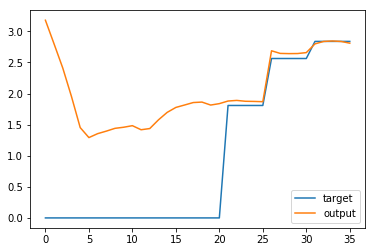

In [68]:
plt.plot(targets[0].data.numpy().T[0][36:72], label='target')
plt.plot(output[0].data.numpy().T[0][36:72], label='output')
plt.legend()
# plt.savefig('./images_for_seminar/training_result1.png', dpi=100)

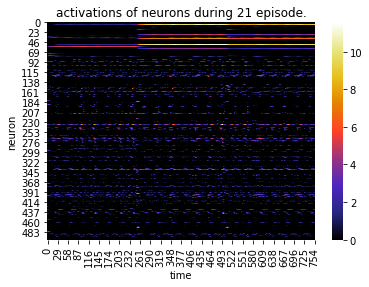

In [69]:
import seaborn as sns
sns.heatmap(hidden_list.data.numpy()[0].T, cmap='CMRmap')
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('activations of neurons during 21 episode.')
plt.savefig('./images_for_seminar/activation_all_episodes_tsd.png', dpi=100)

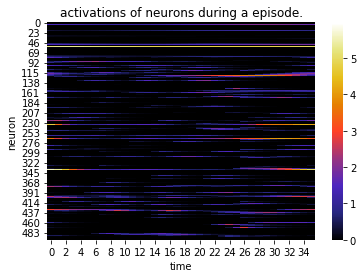

In [70]:
sns.heatmap(hidden_list.data.numpy()[0][36:72].T, cmap='CMRmap')
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('activations of neurons during a episode.')
plt.savefig('./images_for_seminar/activation_1_episode_tsd.png', dpi=100)

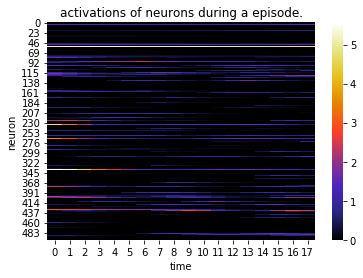

In [71]:
sns.heatmap(hidden_list.data.numpy()[0][36:54].T, cmap='CMRmap')
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('activations of neurons during a episode.')
plt.show()

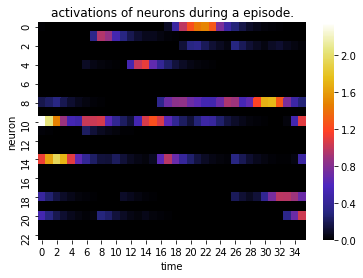

In [72]:
sns.heatmap(hidden_list.data.numpy()[0][36:72].T[368:391], cmap='CMRmap')
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('activations of neurons during a episode.')
plt.show()

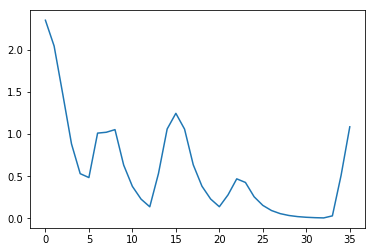

In [73]:
plt.plot(hidden_list.data.numpy()[0][36:72].T[378])

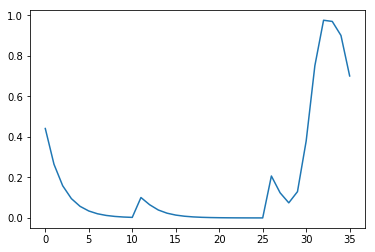

In [74]:
plt.plot(hidden_list.data.numpy()[0][36:72].T[386])

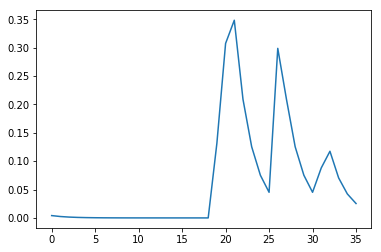

In [75]:
plt.plot(hidden_list.data.numpy()[0][36:72].T[370])

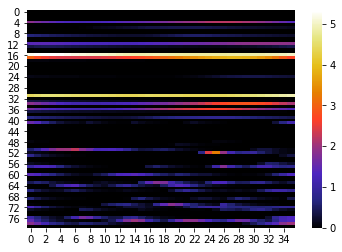

In [76]:
sns.heatmap(hidden_list.data.numpy()[0][36:72].T[40:120], cmap='CMRmap')

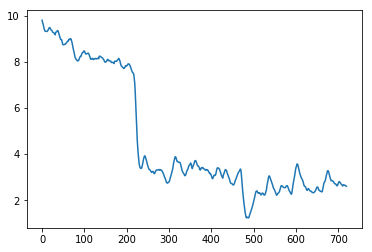

In [22]:
plt.plot(hidden_list.data.numpy()[0][36:].T[56])

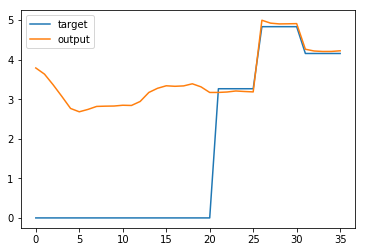

In [96]:
plt.plot(targets[0].data.numpy().T[0][324:360], label='target')
plt.plot(output[0].data.numpy().T[0][324:360], label='output')
plt.legend()

In [97]:
import torch.nn.functional as F
const_one = torch.Tensor([1])
alpha = model.alpha(const_one)

In [86]:
from sklearn.decomposition import PCA

# X = hidden_list.data.numpy()[0]
X = hidden_list.data.numpy()[0]
# X = hidden_list.data.numpy()[0].T[:10].T
const_one = torch.Tensor([1])
alpha = model.alpha(const_one)
thresholded_index = [i for i in range(500) if alpha[i] > 0.1]
        # thresholded_index = [i for i in range(450, 500)]
only_fast_dynamics = np.array([hidden_list.data.numpy()[0].T[i] for i in thresholded_index])
X_o = only_fast_dynamics.T
pca = PCA(n_components=3)
pca.fit(X_o)

Xd = pca.transform(X)

ValueError: operands could not be broadcast together with shapes (756,500) (420,) 

[0, 7, 14]


IndexError: index 2 is out of bounds for axis 0 with size 2

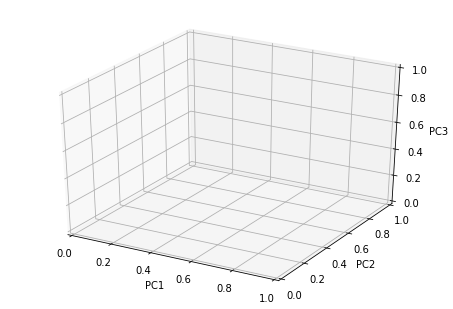

In [87]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap("tab10")
fig = plt.figure()
ax = Axes3D(fig)

when_slow_signal = [0, 7, 14]
slow_signal_values = [1.278, 2.176, 0.451]

# 軸ラベルの設定
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

print(when_slow_signal)

color = 0
for i in range(len(when_slow_signal)-1):
    ax.scatter(Xd.T[0][36*when_slow_signal[i]:36*when_slow_signal[i+1]], 
               Xd.T[1][36*when_slow_signal[i]:36*when_slow_signal[i+1]], 
               Xd.T[2][36*when_slow_signal[i]:36*when_slow_signal[i+1]],
               color=cmap(i), label='{:.3f}'.format(slow_signal_values[i]))
    color += 1
    
ax.scatter(Xd.T[0][36*when_slow_signal[-1]:], 
           Xd.T[1][36*when_slow_signal[-1]:], 
           Xd.T[2][36*when_slow_signal[-1]:],
           color=cmap(color), label='{:.3f}'.format(slow_signal_values[-1]))
plt.legend()
# plt.savefig('./images_for_seminar/visualize_pca_3_tsd_only_fast.png', dpi=100)


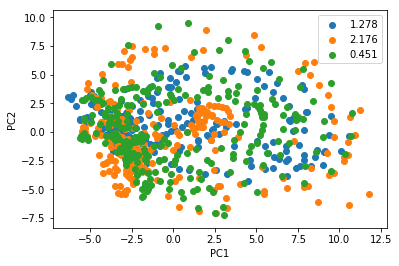

In [85]:


# X = hidden_list.data.numpy()[0]
X = hidden_list.data.numpy()[0]
const_one = torch.Tensor([1])
alpha = model.alpha(const_one)
thresholded_index = [i for i in range(500) if alpha[i] > 0.1]
        # thresholded_index = [i for i in range(450, 500)]
only_fast_dynamics = np.array([hidden_list.data.numpy()[0].T[i] for i in thresholded_index])
X = only_fast_dynamics.T
# X = hidden_list.data.numpy()[0].T[:10].T
pca = PCA(n_components=2)
pca.fit(X)

Xd = pca.transform(X)
cmap = plt.get_cmap("tab10")
fig = plt.figure()

when_slow_signal = [0, 7, 14]
slow_signal_values = [1.278, 2.176, 0.451]

# 軸ラベルの設定
plt.xlabel("PC1")
plt.ylabel("PC2")


color = 0
for i in range(len(when_slow_signal)-1):
    plt.scatter(Xd.T[0][36*when_slow_signal[i]:36*when_slow_signal[i+1]], 
               Xd.T[1][36*when_slow_signal[i]:36*when_slow_signal[i+1]], 
               color=cmap(i), label='{:.3f}'.format(slow_signal_values[i]))
    color += 1
    
plt.scatter(Xd.T[0][36*when_slow_signal[-1]:], 
           Xd.T[1][36*when_slow_signal[-1]:], 
           color=cmap(color), label='{:.3f}'.format(slow_signal_values[-1]))
plt.legend()
plt.savefig('./images_for_seminar/visualize_pca_2_tsd_only_fast.png', dpi=100)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap("tab10")
fig = plt.figure()
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

print(when_slow_signal)

color = 0
for i in range(len(when_slow_signal)-1):
    ax.scatter(Xd.T[0][36*when_slow_signal[i]:36*when_slow_signal[i+1]], 
               Xd.T[1][36*when_slow_signal[i]:36*when_slow_signal[i+1]], 
               Xd.T[2][36*when_slow_signal[i]:36*when_slow_signal[i+1]],
               color=cmap(i), label='{:.3f}'.format(slow_signal_values[i]))
    color += 1
    
ax.scatter(Xd.T[0][36*when_slow_signal[-1]:], 
           Xd.T[1][36*when_slow_signal[-1]:], 
           Xd.T[2][36*when_slow_signal[-1]:],
           color=cmap(color), label='{:.3f}'.format(slow_signal_values[-1]))
plt.legend()


In [ ]:
plt.plot(hidden_list.data.numpy()[0].T[0])
plt.xlabel('time')
plt.ylabel('activation')

Text(0,0.5,'activation')

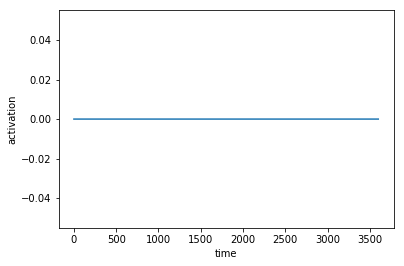

In [10]:
plt.plot(hidden_list.data.numpy()[0].T[1])
plt.xlabel('time')
plt.ylabel('activation')

Text(0,0.5,'activation')

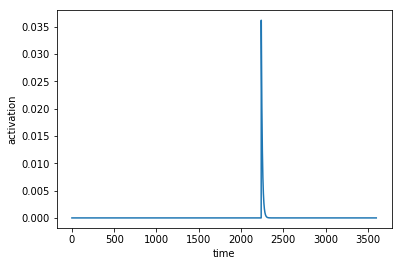

In [11]:
plt.plot(hidden_list.data.numpy()[0].T[2])
plt.xlabel('time')
plt.ylabel('activation')

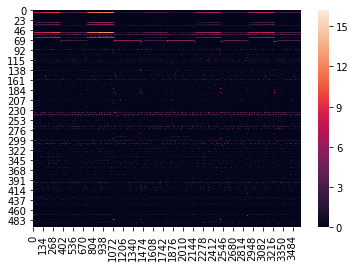

In [12]:
import seaborn as sns
sns.heatmap(hidden_list.data.numpy()[0].T)

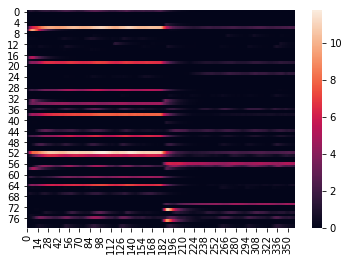

In [18]:
sns.heatmap(hidden_list.data.numpy()[0][:360].T[:80])

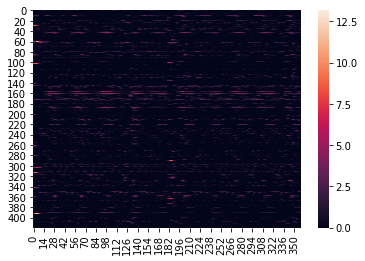

In [19]:
sns.heatmap(hidden_list.data.numpy()[0][:360].T[80:])

In [20]:
use_cuda = False
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = RecurrentNetTimeFixed(n_in=200, n_hid=500, n_out=1,
                                     use_cuda=use_cuda).to(device)
model.load_state_dict(torch.load('../trained_models/04121727_lsmsignals_fxtime_netsize_500_stimdur_7_nstim_3_respdur_5_epoch_751.pth', map_location='cpu'))


cpu


In [21]:
signals = []
targets = []
for i in range(1):
    signal, target = lsm_signals(n_episodes=100,
                                 stim_dur=7,
                                 sig1_stim_dur=7,
                                 resp_dur=5,
                                 each_episodes=5,
                                 spon_rate=0.01,
                                kappa=1.0)
    signals.append(signal)
    targets.append(target)

signals = np.array(signals)
targets = np.array(targets)

signals = torch.from_numpy(signals)
targets = torch.from_numpy(targets)

hidden = torch.zeros(1, 500, requires_grad=False)
hidden = hidden.to(device)


signals = signals.float()
targets = targets.float()

signals, targets = signals.to(device), targets.to(device)

hidden_list, output, hidden = model(signals, hidden)


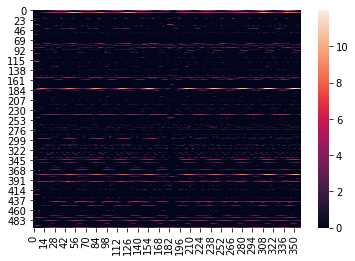

In [22]:
sns.heatmap(hidden_list.data.numpy()[0][:360].T)